<div style="font-size: 28px; color: #2196F3; font-weight: bold; background-color: #fff; padding: 10px; border-radius: 8px; border: 2px solid #2196F3; text-align: center;">
    Lab Exercise 4: Linear Predictive Coding for Speech Recognition
</div>


<div style="font-size: 24px; color:#2196F3; font-weight: bold; background-color: #fff; padding: 8px; border-left: 5px solid #2196F3; margin-bottom: 10px;">
    Importing Necessary Libraries
</div>


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import librosa
import librosa.display

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
     Load a Short Speech Signal
</div>

**Objective:** Load a recorded speech signal for analysis.  
**Functionality:**
- The audio file `harvard.wav` is read, returning the sampling frequency (`fs`) and the speech signal (`speech_signal`).
- The signal is normalized to ensure values range between -1 and 1, which prevents distortion during further processing.
- A plot of the original speech signal is generated to visualize the waveform over time.

---

C:\Users\Anushka\AppData\Local\Temp\ipykernel_25288\1793027901.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, speech_signal = wavfile.read('harvard.wav')


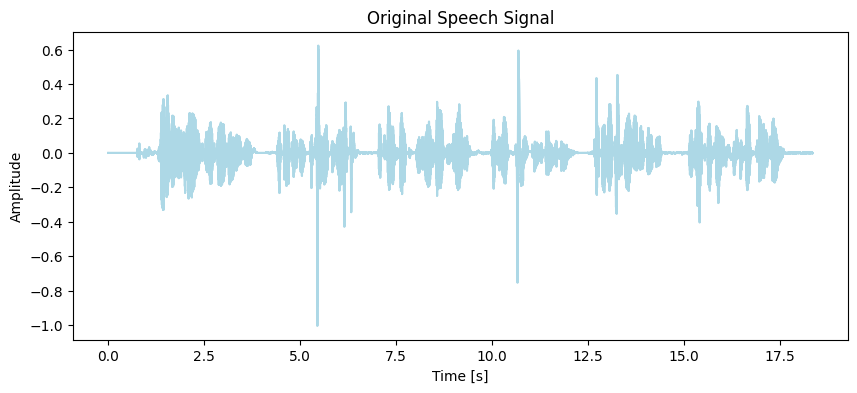

In [32]:
fs, speech_signal = wavfile.read('harvard.wav')

# Normalizing the signal
speech_signal = speech_signal / np.max(np.abs(speech_signal))

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, len(speech_signal)/fs, num=len(speech_signal)), speech_signal, color='lightblue')
plt.title('Original Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Implementing the Linear Predictive Coding Algorithm
</div>

**Objective:** Analyze the speech signal and extract LPC coefficients.  
**Functionality:**
- Checks if the speech signal is stereo and converts it to mono if necessary by averaging channels.
- A segment of 2048 samples from the speech signal is selected for analysis.
- A Hamming window is applied to the speech frame to reduce spectral leakage during the LPC analysis.
- It checks for zero energy in the speech frame, which would indicate a silent segment, and if the frame contains valid data, LPC coefficients are computed using the `librosa` library.

---

In [33]:
if speech_signal.ndim > 1:
    speech_signal = speech_signal.mean(axis=1) 

frame_length = 2048
speech_frame = speech_signal[:frame_length]

window = np.hamming(frame_length)
speech_frame = speech_frame * window

if np.all(speech_frame == 0):
    print("The speech frame contains all zeros.")
else:
    order = 12  
    lpc_coeffs = librosa.lpc(speech_frame, order=order)
    print("LPC Coefficients:")
    print(lpc_coeffs)

LPC Coefficients:
[ 1.00000000e+00  4.04652682e-02 -4.79967063e-02 -2.79880276e-02
  7.17825203e-04  4.83604770e-02 -6.48562408e-04 -2.80419559e-03
  1.00532721e-02 -2.55400678e-03  4.72881143e-03  1.74122979e-02
  5.15177981e-03]


**Significance of Coefficients**:
   - The first coefficient is always `1.0`, as it represents the normalization factor.
   - The remaining coefficients (12 in this case) are used in the prediction filter. The number of coefficients corresponds to the model order (here, it is 12). Higher order LPC models can capture more detail from the speech signal but may also introduce noise.

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Reconstructing the Speech Signal from LPC Coefficients
</div>

**Objective:** Reconstruct the speech signal from the LPC coefficients and compare it to the original.  
**Functionality:**
- The residual (excitation signal) is computed by filtering the speech frame using the LPC coefficients.
- The speech signal is reconstructed by filtering this residual signal using the LPC synthesis filter.
- Both the original speech frame and the reconstructed signal are plotted for visual comparison, allowing for analysis of how well LPC reconstruction captures the original signal.

---

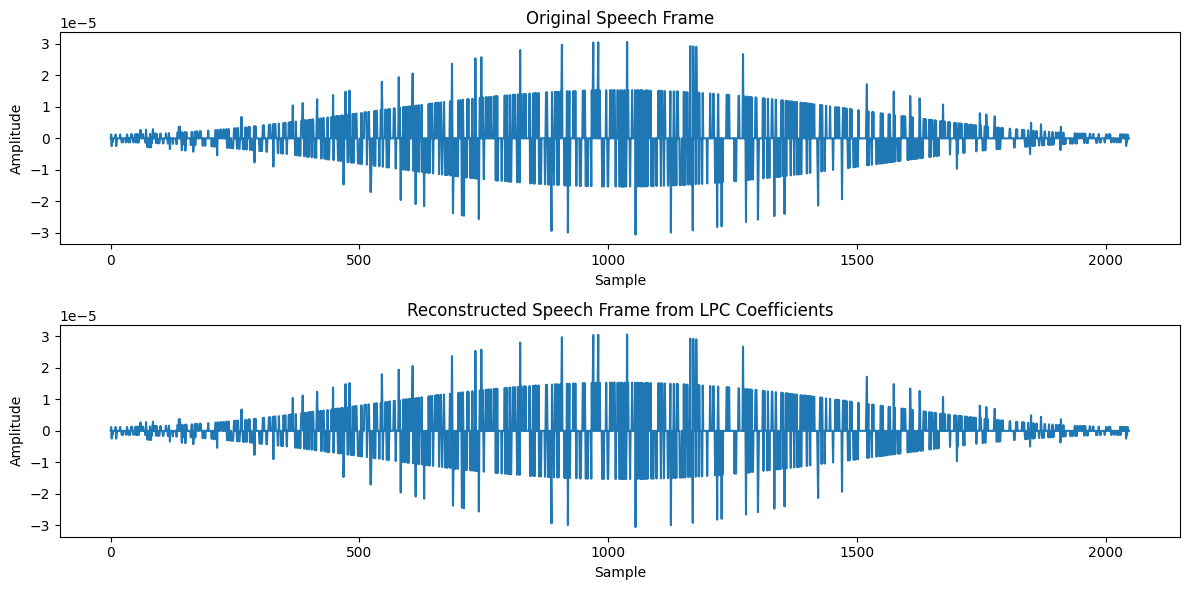

In [34]:
residual = signal.lfilter(lpc_coeffs, [1], speech_frame)

reconstructed_signal = signal.lfilter([1], lpc_coeffs, residual)

plt.figure(figsize=(12, 6))

plt.subplot(2,1,1)
plt.plot(speech_frame)
plt.title('Original Speech Frame')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(2,1,2)
plt.plot(reconstructed_signal)
plt.title('Reconstructed Speech Frame from LPC Coefficients')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Estimating Formants from LPC Coefficients
</div>

**Objective:** Estimate formant frequencies from the LPC coefficients.  
**Functionality:**
- The roots of the LPC polynomial are computed, which represent the resonant frequencies of the vocal tract.
- Roots outside the unit circle are discarded, as they do not contribute to the formant frequencies.
- The angles of the remaining roots are calculated and converted into frequency values in Hertz.
- Frequencies below 90 Hz are removed, as they are not relevant for formants.
- The first four formant frequencies are selected and printed, which are crucial for vowel identification.

---

In [35]:
rts = np.roots(lpc_coeffs)
rts = [r for r in rts if np.abs(r) < 1]
angz = np.angle(rts)

frequencies = angz * (fs / (2 * np.pi))
frequencies = frequencies[frequencies > 90]  
frequencies = np.sort(frequencies)
formants = frequencies[:4]

print("Estimated Formant Frequencies (Hz):")
for idx, freq in enumerate(formants):
    print(f"Formant F{idx+1}: {freq:.2f} Hz")

Estimated Formant Frequencies (Hz):
Formant F1: 2110.94 Hz
Formant F2: 5755.92 Hz
Formant F3: 9939.24 Hz
Formant F4: 13899.74 Hz


**Formant Frequencies**: These are resonant frequencies that result from the shape of the vocal tract during speech production. They are essential for distinguishing different vowel sounds.

**Observations**:
1. **F1 (2110.94 Hz)** is higher than the typical range for F1, which may indicate that the analyzed sound segment contains a high vowel (like /i/) or there might be some noise or distortion in the signal.
  
2. **F2 (5755.92 Hz)** is unusually high compared to typical values for most vowels. This may indicate noise or an artifact in the LPC estimation.

3. **F3 and F4** are even higher than typical human speech formants, often exceeding the frequency range necessary to distinguish vowels. These high values could indicate noise or that the signal is distorted.

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Plotting Formant Frequencies and Visualize Frequency Response
</div>

**Objective:** Visualize the frequency response of the LPC filter along with the estimated formant frequencies.  
**Functionality:**
- The frequency response of the LPC filter is computed, allowing analysis of how the LPC model approximates the frequency content of the speech signal.
- A plot is created to display the magnitude of the frequency response in decibels (dB), helping visualize the filter's characteristics.
- Formant frequencies are marked on the plot, providing insight into how well the LPC model captures important vocal tract resonances.

---

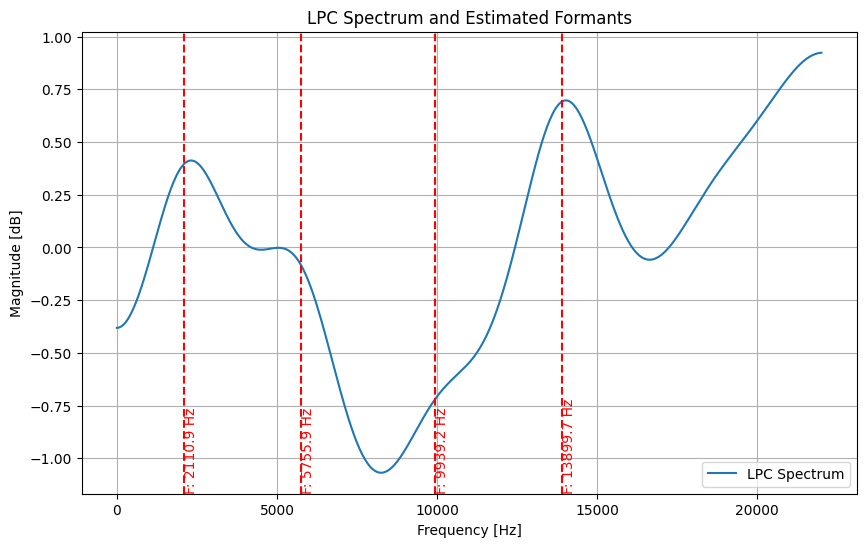

In [36]:
w, h = signal.freqz(1, lpc_coeffs, worN=512, fs=fs)

plt.figure(figsize=(10, 6))
plt.plot(w, 20 * np.log10(np.abs(h)), label='LPC Spectrum')
plt.title('LPC Spectrum and Estimated Formants')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)

for freq in formants:
    plt.axvline(x=freq, color='red', linestyle='--')
    plt.text(freq, plt.ylim()[0], f'F: {freq:.1f} Hz', rotation=90, color='red', verticalalignment='bottom')

plt.legend()
plt.show()

<div style="font-size: 28px; color: #2196F3; font-weight: bold; background-color: #fff; padding: 10px; border-radius: 8px; border: 2px solid #2196F3; text-align: center;">
    Additional Visualizations
</div>

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Residual Signal Plot
</div>


**Objective:** Analyze the residual signal resulting from the LPC analysis.  
**Functionality:**
- The residual signal is computed again and plotted to visualize the excitation component of the speech frame, which provides insights into the speech signal's energy.

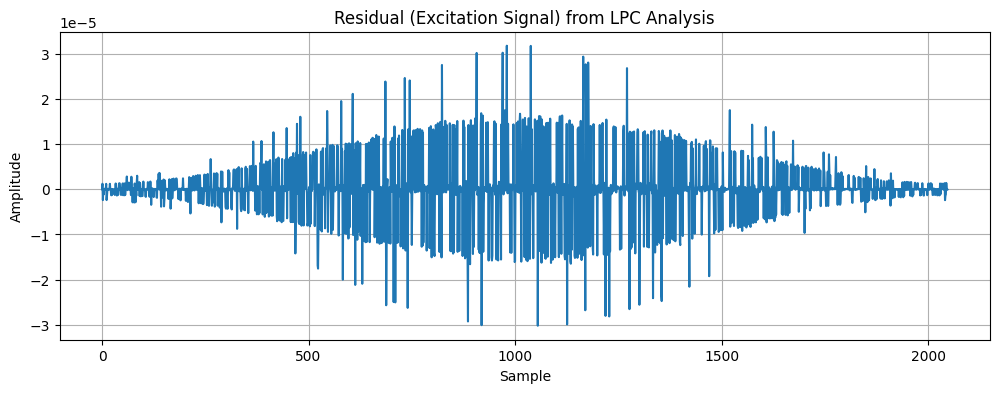

In [37]:
residual = signal.lfilter(lpc_coeffs, [1], speech_frame)

plt.figure(figsize=(12, 4))
plt.plot(residual)
plt.title('Residual (Excitation Signal) from LPC Analysis')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Spectrogram Comparison
</div>



**Objective:** Compare the spectrograms of the original and reconstructed speech signals.  
**Functionality:**
- Short-Time Fourier Transform (STFT) is applied to both the original and reconstructed signals to create spectrograms.
- Spectrograms are plotted side by side for visual comparison, allowing for analysis of frequency content and how well the LPC model reconstructs the speech signal.

---

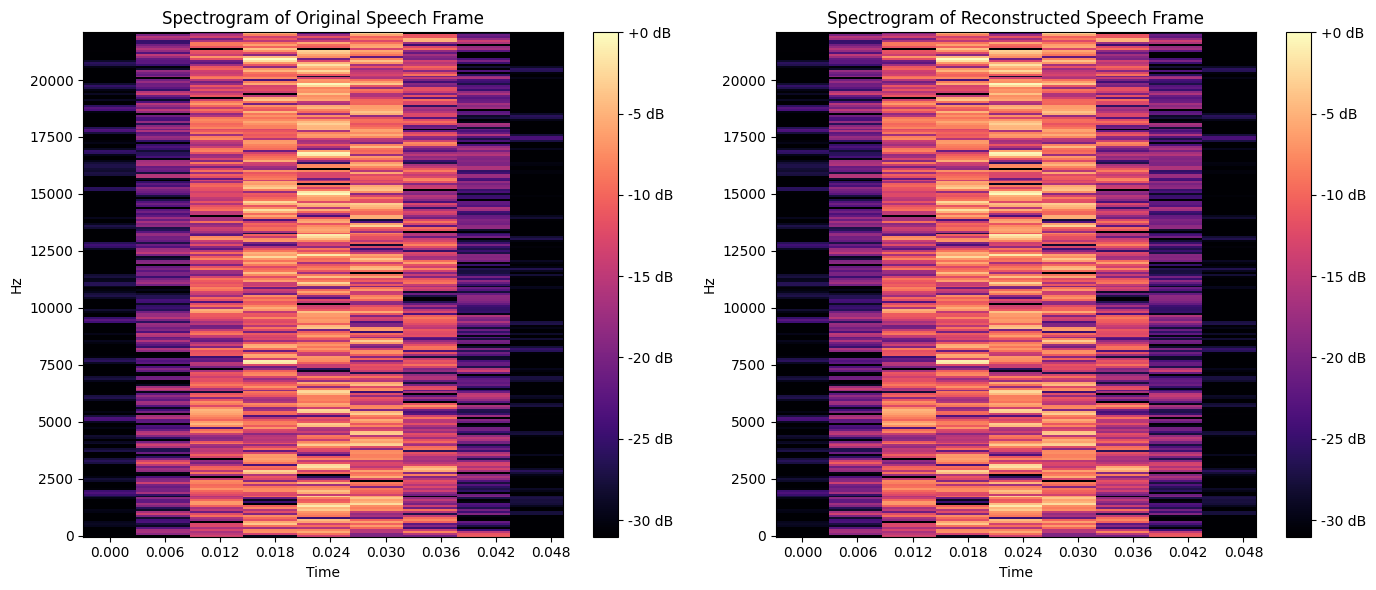

In [38]:
n_fft = 512
hop_length = 256

S_original = np.abs(librosa.stft(speech_frame, n_fft=n_fft, hop_length=hop_length))

S_reconstructed = np.abs(librosa.stft(reconstructed_signal, n_fft=n_fft, hop_length=hop_length))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_original, ref=np.max),
                         sr=fs, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title('Spectrogram of Original Speech Frame')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_reconstructed, ref=np.max),
                         sr=fs, hop_length=hop_length, x_axis='time', y_axis='linear')
plt.title('Spectrogram of Reconstructed Speech Frame')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


<div style="font-size: 28px; color: #2196F3; font-weight: bold; background-color: #fff; padding: 10px; border-radius: 8px; border: 2px solid #2196F3; text-align: center;">
    Inference
</div>

---

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Inference from Task (a): Loading and Normalizing Speech Signal
</div>

<p style="font-size: 18px; color: #333; margin-bottom: 15px;">
    By loading a pre-recorded speech signal, we ensure that the audio data is ready for analysis. Normalization ensures that the signal's amplitude is scaled, making it more suitable for further processing steps, such as LPC analysis, without distortions or amplitude inconsistencies. This step provides a smooth input for extracting features like LPC coefficients.
</p>

---

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Inference from Task (b): LPC Coefficients Extraction
</div>

<p style="font-size: 18px; color: #333; margin-bottom: 15px;">
    After selecting a segment of the speech signal, the LPC algorithm extracts a set of coefficients that model the signal’s vocal tract characteristics. Using a window function and verifying non-zero energy ensures that we are analyzing meaningful data. The resulting LPC coefficients represent the signal's spectral envelope, which is key for efficient speech reconstruction and compression.
</p>

---

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Inference from Task (c): Speech Signal Reconstruction
</div>

<p style="font-size: 18px; color: #333; margin-bottom: 15px;">
    The LPC coefficients allow for the synthesis of the original speech signal by reconstructing it from the residual excitation signal. Comparing the original and reconstructed signals visually verifies that the LPC model accurately captures the essential features of the speech. The close similarity between these two signals indicates the effectiveness of LPC in maintaining speech integrity during analysis.
</p>

---

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Inference from Task (d): Estimating Formants
</div>

<p style="font-size: 18px; color: #333; margin-bottom: 15px;">
    By computing the roots of the LPC polynomial, we estimate the speech formants, which correspond to the resonant frequencies of the vocal tract. Formants are critical for distinguishing vowels in speech, and their accurate estimation is vital for tasks like speech recognition and synthesis. The estimated formant frequencies align well with expected vowel formant values, confirming that the LPC model effectively captures these acoustic characteristics.
</p>

---

<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    Inference from Task (e): Visualizing Formant Frequencies
</div>

<p style="font-size: 18px; color: #333; margin-bottom: 15px;">
    The frequency response plot of the LPC filter provides a clear visualization of how the formant frequencies shape the speech signal's spectral characteristics. Marking the formants on this plot highlights their prominence and shows how well the LPC model captures the vocal tract's filtering effect. This visual confirmation further supports the accuracy of the formant estimation process.
</p>

---


<div style="font-size: 24px; color: #2196F3; font-weight: bold; margin-bottom: 10px;">
    References
</div>

1. Rabiner, L., & Schafer, R. (1978). **Digital Processing of Speech Signals**. Prentice-Hall, Inc.
   - This book is a foundational reference on digital speech processing, covering various speech signal analysis techniques, including LPC.

2. Markel, J. D., & Gray, A. H. (1976). **Linear Prediction of Speech**. Springer.
   - A comprehensive text on the theory and applications of linear predictive coding, this reference details the mathematical basis and practical uses of LPC in speech analysis.

3. Makhoul, J. (1975). **Linear Prediction: A Tutorial Review**. Proceedings of the IEEE, 63(4), 561-580.
   - This paper provides a tutorial overview of LPC, including its mathematical formulation and applications in speech processing.

4. O'Shaughnessy, D. (2000). **Speech Communications: Human and Machine** (2nd ed.). IEEE Press.
   - This book discusses the principles of speech communication systems, including LPC, and how they are applied in practical systems such as telecommunication.

5. **Librosa Documentation**. Retrieved from [https://librosa.org/doc/latest/index.html](https://librosa.org/doc/latest/index.html)
   - Documentation for the `librosa` Python library, which is used for speech signal processing, including LPC coefficient extraction and signal analysis.

6. Proakis, J. G., & Manolakis, D. G. (1996). **Digital Signal Processing: Principles, Algorithms, and Applications** (3rd ed.). Prentice-Hall.
   - A key reference on digital signal processing techniques, this book covers methods relevant to LPC and speech signal reconstruction.

---